# Genre Binary Classification on Musical Acoustic Features
## Project D7041E, Applied Artificial Intelligence
### Group 10 - Fernando Labra Caso (ferlab-1), Nicolas Scheidler (nicsch-3), Alexis Delgorgue (aledel-3)

This project aims to perform a classification task between two musical genres based on acoustic continuous features with Self Organizing Maps (SOM) and Support Vector Machine (SVM), two Machine Learning (ML) techniques.

## Requirements & Global Variables

The implementation has been done with:

* **Python - 3.10.12** &nbsp; &nbsp; &nbsp; &nbsp;  High-level, general-purpose programming language.
* **Numpy - 1.23.5** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Library with support for large, multi-dimensional arrays and matrices.
* **Pandas - 2.1.4** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Open source data analysis and manipulation tool.
* **Scikit Learn - 1.3.2** &nbsp; &nbsp; Library with tools for predictive data analysis.
* **Matplotlib - 3.8.2** &nbsp; &nbsp; &nbsp; Plotting library for creating static, animated, and interactive visualizations
* **Seaborn - 0.13.1** &nbsp; &nbsp; &nbsp; &nbsp; Data visualization library based on Matplotlib.
* **PyTorch - 2.0.0** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Machine Learning framework based on the Torch library.

In [1]:
import math
import time

import numpy as np
import numpy.matlib

from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### 

numpy.random.seed(int(time.time()))
plt.set_cmap(plt.get_cmap('viridis'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Figure size 640x480 with 0 Axes>

## Dataset Exploration

The dataset contains 10697 samples of spotify songs with information about their danceability, energy, key, loudness, mode, speechiness, acousticneess, instrumentalness, liveness, valence, tempo and duration. The characteristics of the data and the complexity of multi-classification with ML models on a short time has led us to choose binary classification instead.

The classification will be done on rap and rock genres with a model constructed to differentiate between songs based on their acoustic features. Songs belonging to these two genres are used for classification during later processing.

In [2]:
data = pd.read_csv("/kaggle/input/30000-spotify-songs/spotify_songs.csv")
data = data.loc[data['playlist_genre'].isin(['rap', 'rock'])]
x = data[data.keys()[11:]];  y = pd.Categorical(data['playlist_genre']).codes

print("Label:\t\t",  list(data['playlist_genre'].unique()).__str__()) # 0 to 5 classes
print("Features:\t", list(x.keys()), "\n")

x.describe()

Label:		 ['rap', 'rock']
Features:	 ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'] 



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,10697.000000,10697.000000,10697.000000,10697.000000,10697.000000,10697.000000,10697.000000,10697.000000,10697.000000,10697.000000,10697.000000,10697.000000
mean,0.626801,0.688710,5.349724,-7.295270,0.604188,0.132796,0.170591,0.069712,0.196968,0.520022,122.660800,230091.423764
std,0.169653,0.186463,3.622866,3.220753,0.489047,0.123409,0.216246,0.206226,0.159278,0.227401,30.115323,65033.027238
min,0.000000,0.016100,0.000000,-26.207000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,0.503000,0.566000,2.000000,-8.990000,0.000000,0.040500,0.011900,0.000000,0.095300,0.346000,96.048000,188349.000000
50%,0.634000,0.705000,6.000000,-6.691000,1.000000,0.074500,0.077500,0.000009,0.132000,0.523000,122.259000,224160.000000
75%,0.762000,0.839000,9.000000,-5.020000,1.000000,0.203000,0.249000,0.002630,0.262000,0.696000,143.966000,265173.000000
max,0.975000,0.999000,11.000000,1.275000,1.000000,0.877000,0.994000,0.974000,0.996000,0.991000,211.644000,517125.000000


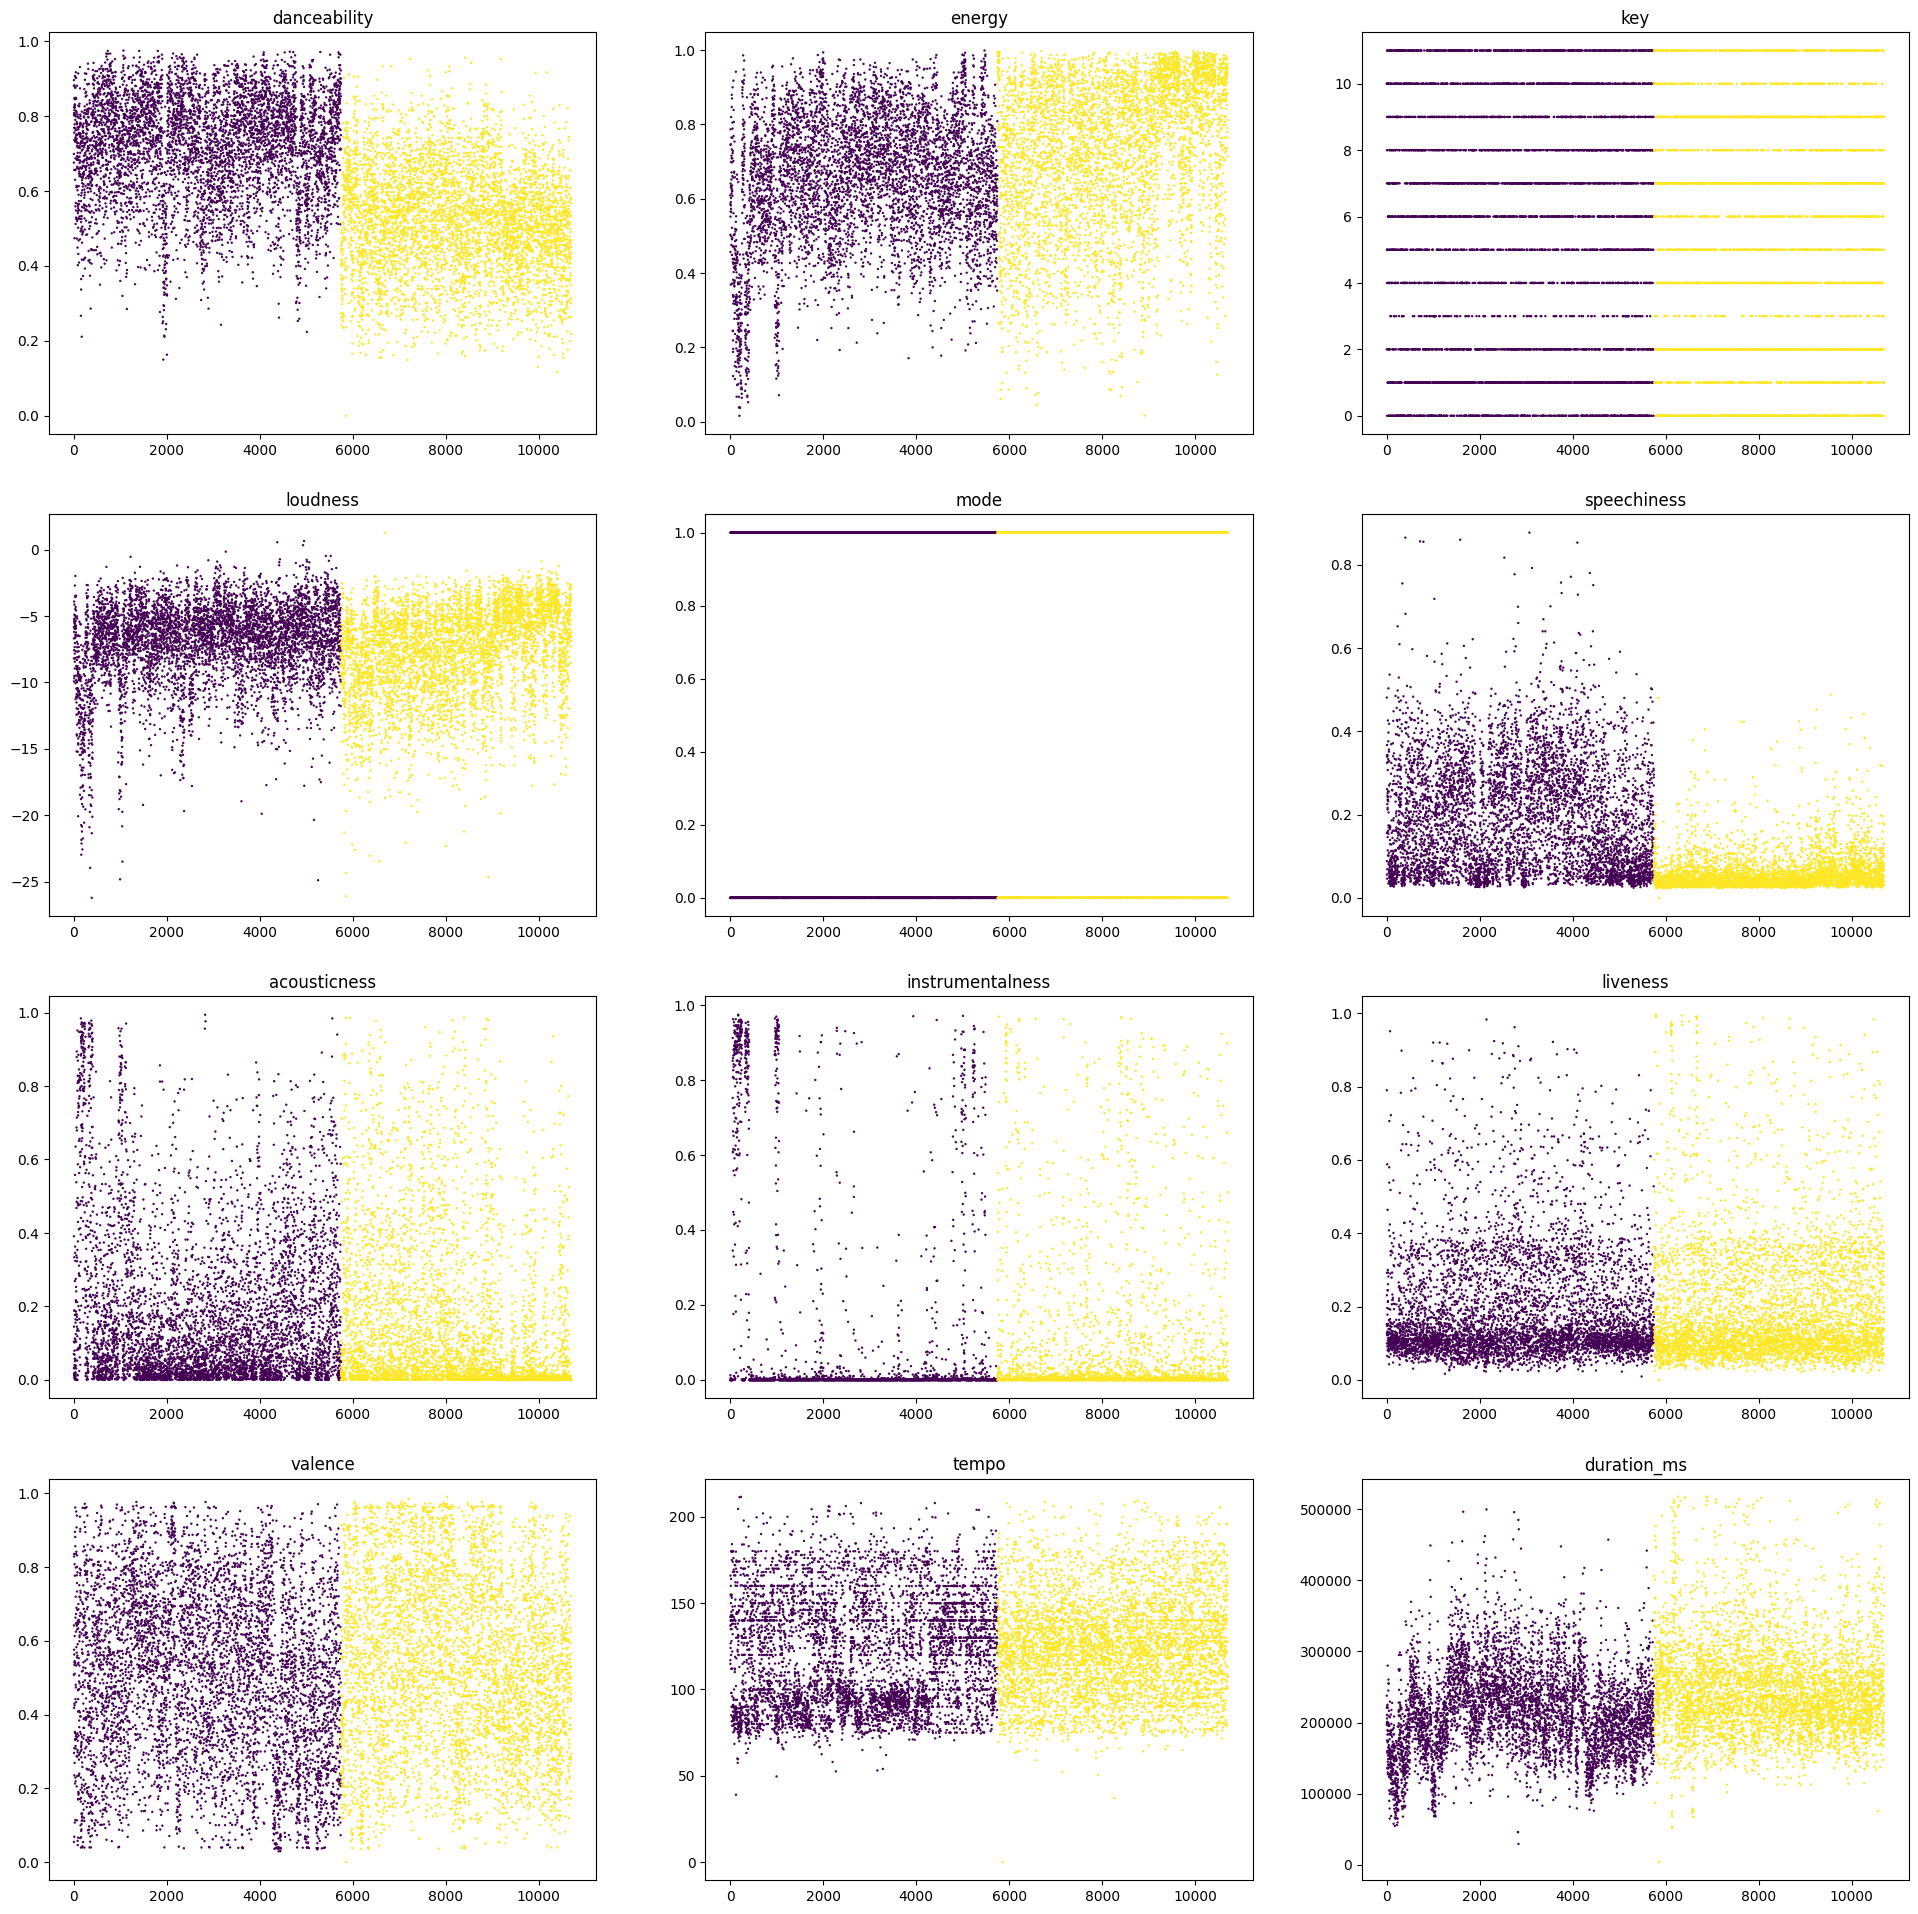

In [3]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24, 24))
idx = np.linspace(1, x.shape[0], x.shape[0], dtype=np.uint32)

row = 0;  column = 0
for key in x.keys():
    axis[row, column].set_title(key)
    axis[row, column].scatter(idx, x[key],c=y, s=0.5)
    column += 1
    if column == 3:  row += 1;  column = 0

We can see in the results the rock and rap songs with rather similar values on most features with the exception of the danceability and speechness that show, perhaps logically a better differentiation.

## Dataset Preprocessing

As a preprocessing, the data is divided onto train, validation and test sets. Some other techniques include (1) Normalization, (2) Standardization and (3) Decorelation by Singular Value Decomposition (SVD) on each of the different sets for keeping biases and other information independent. These steps will help on faster convergence to a local minima from the models and independence of different features between each other.

In [4]:
# Dataset Division (Train 0.6 // Validation 0.2 // Test 0.2)
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size=0.4, train_size=0.6)
x_val, x_test, y_val, y_test   = train_test_split(x_aux, y_aux, test_size=0.5, train_size=0.5)

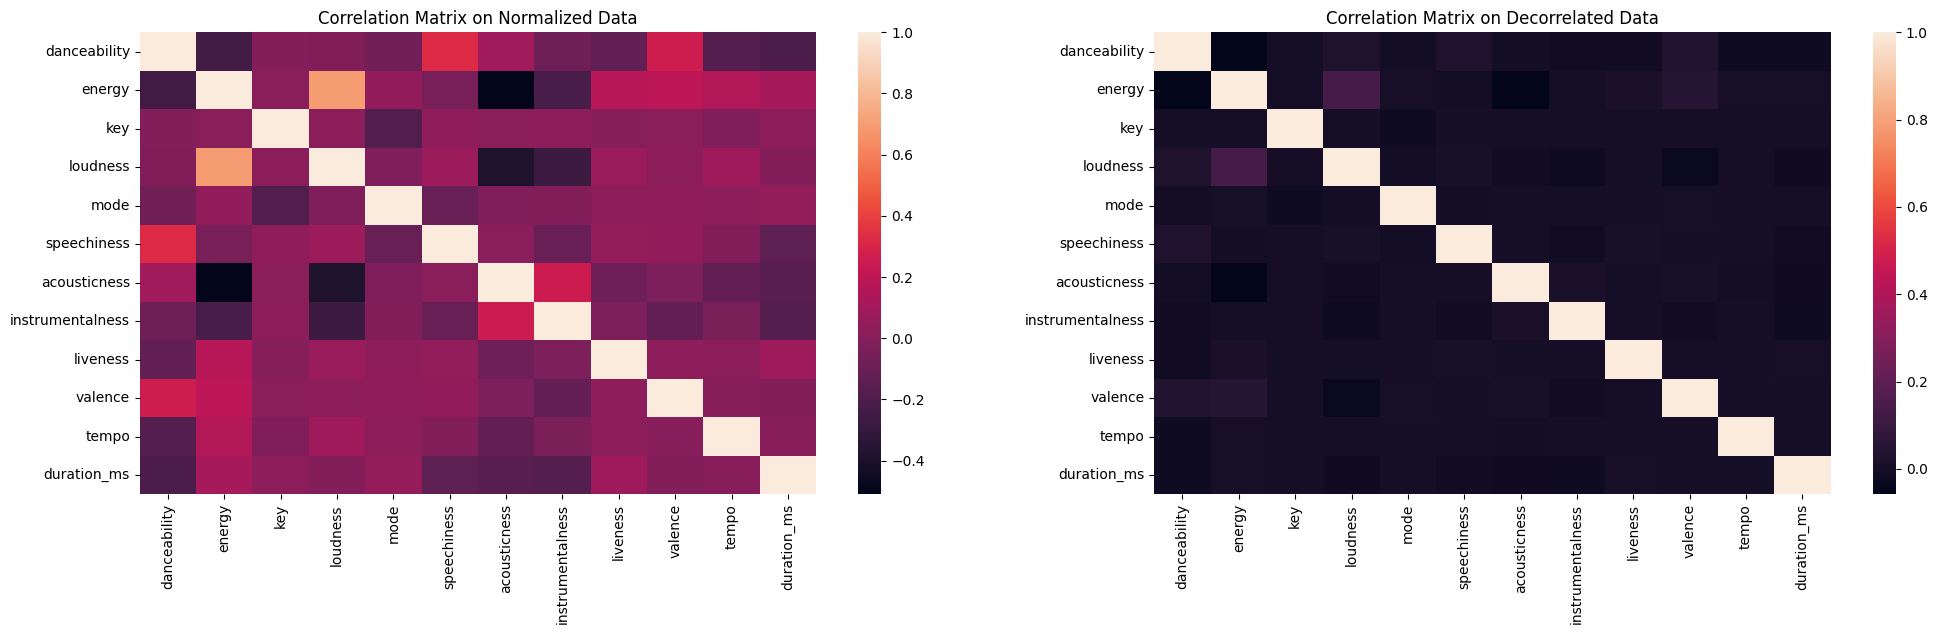

In [5]:
# Normalization & Standardization
x_norm_list = [x_train.copy(), x_val.copy(), x_test.copy()]
for idx, x_norm in enumerate(x_norm_list, 0):
    for i in x_norm.columns: 
        x_norm[i] = (x_norm[i] - x_norm[i].mean()) / x_norm[i].std()   
    x_norm_list[idx] = x_norm
    
# Decorrelation (SVD)
x_decor_list = [x_norm_list[0].copy(), x_norm_list[1].copy(), x_norm_list[2].copy()]
for idx, (x_norm, x_decor) in enumerate(zip(x_norm_list, x_decor_list)):
    cov = np.cov(x_norm, rowvar=False, bias=True)
    U, S, _ = np.linalg.svd(cov)  

    epsilon = 0.1
    x_decor = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(x_norm.T).T
    x_decor = (x_decor - x_decor.min()) / (x_decor.max() - x_decor.min())
    x_decor = pd.DataFrame(data=x_decor, columns=x_norm.columns)
    
    x_decor_list[idx] = x_decor

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
for idx, (x_type, x_title) in enumerate(zip([x_norm_list[0], x_decor_list[0]], ["Normalized Data", "Decorrelated Data"]), 0):
    axis[idx].set_title("Correlation Matrix on " + x_title)
    heatmap = x_type.corr(); round(heatmap, 2);  sns.heatmap(heatmap, ax=axis[idx]);

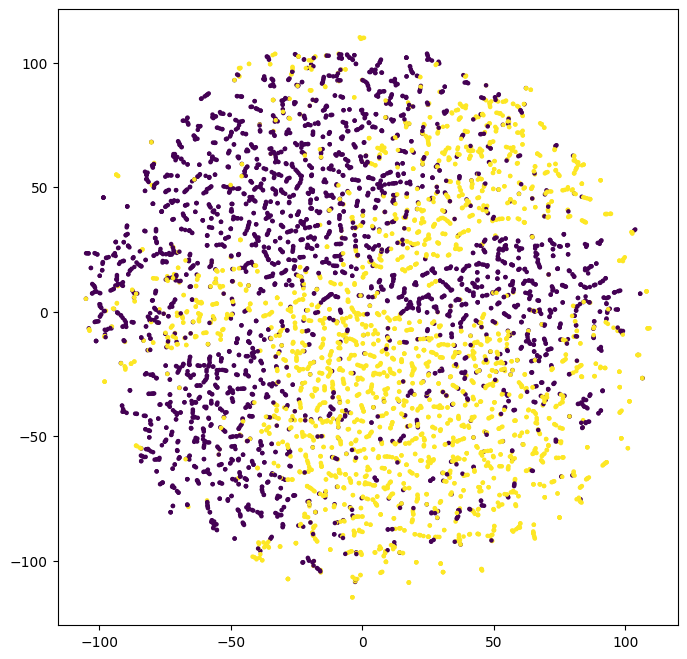

In [6]:
x_embbed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(x_decor_list[0])
plt.figure(figsize=(8, 8))
plt.scatter(x_embbed[:, 0].flatten(), x_embbed[:, 1].flatten(), s=5, c=y_train)

With t-SNE embedding visualization, the high-dimensional separation can be appreciated. Although some rap songs are distant to their majority cluster (perhaps some rap-rock mixture) a non-linear classifier that divides both classes on the aforementioned features should be learnable.

## SOM Unsupervised Embedding

SOM is an unsupervised machine learning technique used to produce a low-dimensional representation of a higher dimensional dataset while preserving the topological structure of the data. For example, a dataset with $p$ variables measured in $n$ observations could be represented as clusters of observations with similar values for the variables. This can make high-dimensional data easier to visualize and analyze.

First, training uses an input data set (the "input space") to generate a lower-dimensional representation of the input data (the "map space"). Second, mapping classifies additional input data using the generated map.

================================================================================================

The idea for applying SOM to this dataset is to find a similar mapping as the one aplied with t-SNE (which is not feasible for classification) from high to lower dimensions capable of generalizing to new samples.

In [7]:
def L2(p: np.ndarray, array: np.ndarray):
    nrows, ncols = array.shape[0], array.shape[1]
    p_array = array.copy().reshape((nrows * ncols, array.shape[2]))
    return np.sqrt(np.sum(np.square(p_array - p), axis=1)).reshape((nrows, ncols))

###

def som_train(data:np.ndarray, ndim:int=10, epochs:int=10, eta0:float=0.1, eta_decay:float=0.05, sgm0:float=20, sgm_decay:float=0.05):

    # Obtain initial dimensions
    nsamples, nfeatures = data.shape[0], data.shape[1]
    nrows, ncols = ndim, ndim

    # Generate initial neuron weights
    mu, sigma = 0, 0.1
    som_model = np.random.normal(mu, sigma, (nrows, ncols, nfeatures))

    # Generate coordinate system
    x, y = np.meshgrid(range(ncols),range(nrows))
    
    for t in range(1, epochs+1):
        # Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t * eta_decay)
        
        # Compute the variance of the Gaussian (Neighbourhood) function for the current epoch
        sgm = sgm0 * math.exp(-t * sgm_decay)
        
        # Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm*3)
        
        for idx_sample in range(nsamples):
            sample = data[idx_sample].flatten()

            # Compute the Euclidean distance between the sample and each neuron in the SOM map
            distance = L2(sample, som_model)
       
            # Find 2D coordinates of the Best Matching Unit (BMU)
            bmu_row, bmu_col = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
            
            # Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmu_col,2)) + (np.power(y - bmu_row,2))) / (2*(sgm**2)))

            # Determine the boundary of the local neighbourhood
            row_min = max(0, bmu_row - width);  row_max = min(bmu_row + width, nrows)
            col_min = max(0, bmu_col - width);  col_max = min(bmu_col + width, ncols)
            
            # Get the neighbouring neurons and determine the size of the neighbourhood
            neighbours = som_model[row_min:row_max, col_min:col_max, :]

            # Transform sample into multi-dimensional
            sample_multi = np.matlib.repmat(sample, m=neighbours.shape[0]*neighbours.shape[1], n=1)\
                                    .reshape((neighbours.shape[0], neighbours.shape[1], nfeatures))     
                          
            # Transform Gaussian function into multi-dimensional (Stack along third axis aka features)
            g_multi = np.dstack([g[row_min:row_max, col_min:col_max]] * nfeatures) 

            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbours = neighbours + eta * g_multi * (sample_multi - neighbours)
            
            #Put the new weights of the BMU neighbouring neurons back to the entire SOM map
            som_model[row_min:row_max, col_min:col_max, :] = neighbours

    return som_model

###

def som_test(data:np.ndarray, gt:np.ndarray, ndim:int, som_model:np.ndarray, nclasses:int):
    
    # Obtain initial dimensions
    nsamples = data.shape[0]
    nrows, ncols = ndim, ndim

    # Build testing structs    
    som_grid = np.zeros((nrows, ncols), dtype=np.uint32)                # SOM class prediction
    som_classes = np.zeros((ndim, ndim, nclasses), dtype=np.uint32)     # SOM class frequency
    
    for idx_sample in range(nsamples):
        sample = data[idx_sample].flatten()
        idx_class = gt[idx_sample]

        # Compute the Euclidean distance between the sample and each neuron in the SOM map
        distance = L2(sample, som_model)
       
        # Find 2D coordinates of the Best Matching Unit (BMU)
        bmu_row, bmu_col = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
        
        som_classes[bmu_row, bmu_col, idx_class] += 1
    
    for i in range (nrows):
        for j in range (ncols):
            som_grid[i, j] = np.argmax(som_classes[i, j, :])
        
    return som_grid

###

def som_confusion(data:np.ndarray, gt:np.ndarray, som_model:np.ndarray, som_grid: np.ndarray, nclasses:int):
    nsamples = data.shape[0]
    som_confusion = np.zeros((nclasses, nclasses), dtype=np.uint32)     # Confusion Matrix of Predicted and Target classes

    for idx_sample in range(nsamples):
        sample = data[idx_sample].flatten()
        idx_class = gt[idx_sample]
        
        # Compute the Euclidean distance between the sample and each neuron in the SOM map
        distance = L2(sample, som_model)
    
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmu_row, bmu_col = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
        
        som_confusion[idx_class, som_grid[bmu_row, bmu_col]] += 1

    return som_confusion

In [8]:
models_path = '/kaggle/working/'

x_som_train = np.concatenate((x_decor_list[0], x_decor_list[1]))
y_som_train = np.concatenate((y_train, y_val))

x_som_test = x_decor_list[2].to_numpy()
y_som_test = pd.Categorical(y_test).codes

ndim = 48
som_model = som_train(x_som_train, ndim, epochs=10)
np.save(models_path + 'som_' + str(ndim) + 'x' + str(ndim), som_model, allow_pickle=False)

Text(0.5, 1.0, 'Confusion Matrix Test 48x48')

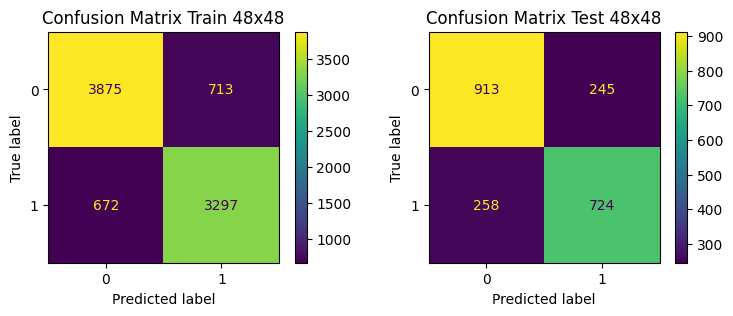

In [9]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

som_model = np.load(models_path + 'som_' + str(ndim) + 'x' + str(ndim) + '.npy', allow_pickle=False)
som_grid = som_test(x_som_train, y_som_train, ndim, som_model, nclasses=6)

som_confusion_train = som_confusion(x_som_train, y_som_train, som_model, som_grid, nclasses=2)

ConfusionMatrixDisplay(som_confusion_train).plot(ax=axis[0])
axis[0].set_title('Confusion Matrix Train ' + str(ndim) + 'x' + str(ndim))

som_confusion_test = som_confusion(x_som_test, y_som_test, som_model, som_grid, nclasses=2)

ConfusionMatrixDisplay(som_confusion_test).plot(ax=axis[1])
axis[1].set_title('Confusion Matrix Test ' + str(ndim) + 'x' + str(ndim))

The results are successful and display correct division of samples on both train and test sets, reaching generalization. Some songs are not correctly identified, probably related to the high-dimensional group of songs separated from their main cluster and to hyperparameter selection that needs to be optimized. 

## SVM Supervised Classification

SVM is a supervised max-margin model. In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

More formally, SVM constructs a hyperplane in a high dimensional space. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class, since in general the larger the margin, the lower the generalization error of the classifier.

================================================================================================

The reason behind choosing this model is once again, the possibility of building non-linear functions capable of dividing the groups as we saw with t-SNE and SOM.

OneVsRest Polynomial Kernel :: Accuracy 0.9205236091631603 :: F1-Score 0.9201040758500436


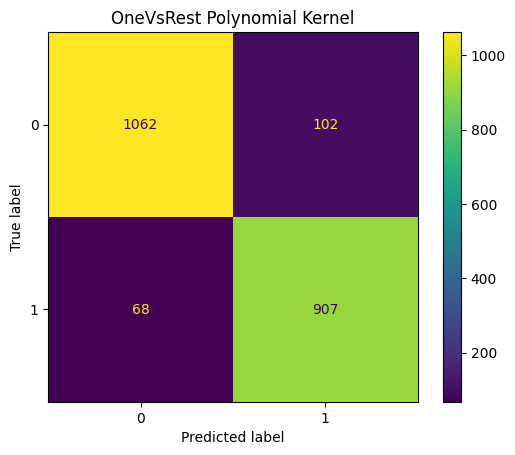

In [10]:
# Instantiate SVM models with different kernels
model = OneVsRestClassifier(svm.SVC(kernel = "poly")).fit(x_decor_list[0], y_train)
y_pred = model.predict(x_decor_list[1])

# Obtain evaluation metrics
title = 'OneVsRest Polynomial Kernel'
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

print('{0} :: Accuracy {1} :: F1-Score {2}'.format(title, accuracy, f1))
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred, labels=[0, 1])).plot()
plt.title(title)
plt.show()

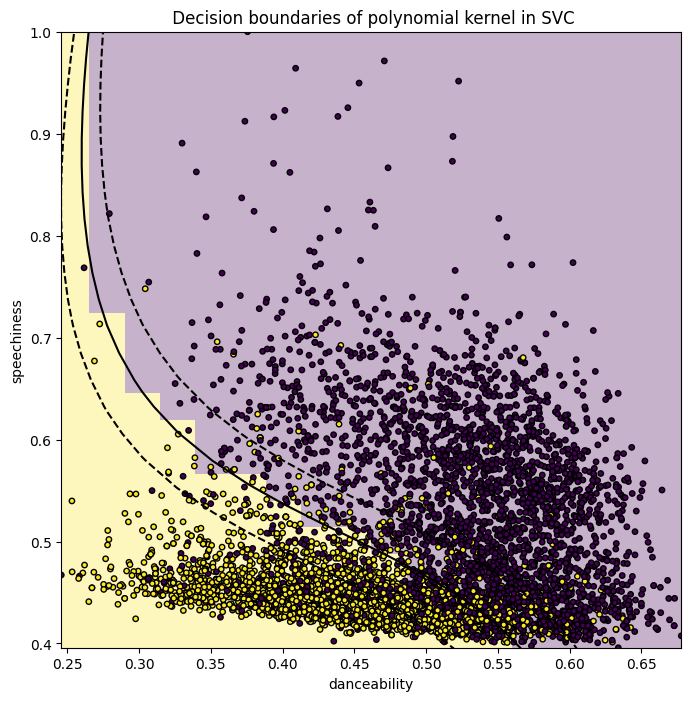

In [11]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html

# Settings for plotting
X = x_decor_list[0][['danceability', 'speechiness']]
clf = svm.SVC(kernel="poly").fit(X, y_train)

_, ax = plt.subplots(figsize=(8, 8))
x_min, x_max, y_min, y_max = X['danceability'].min(), X['danceability'].max(), X['speechiness'].min(), X['speechiness'].max()
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Plot decision boundary and margins
common_params = {"estimator": clf, "X": X, "ax": ax}
DecisionBoundaryDisplay.from_estimator(**common_params, response_method="predict", plot_method="pcolormesh", alpha=0.3)
DecisionBoundaryDisplay.from_estimator(**common_params, response_method="decision_function", plot_method="contour", levels=[-1, 0, 1], colors=["k", "k", "k"], linestyles=["--", "-", "--"])

# Plot samples by color and add legend
ax.scatter(X['danceability'], X['speechiness'], c=y_train, s=15, edgecolors="k")
ax.set_title(f" Decision boundaries of polynomial kernel in SVC")

plt.show()

Results show great separation of samples, through danceability and speechiness features it's possible to train another algorithm and visualize the decision boundary and the margins.

Both SOM and SVM are great classifiers of high-dimensional features for this dataset.

The group strongly believes that the learning of a non-linear classifier through Neural Networks (NN) is more than possible as long as non-linear activations are used, the group wanted to demonstrate that other techniques besides NNs with backpropagation are capable of doing this.

The next section focuses on using a NN to solve this classification problem. This is done by using a MultiLayer Perceptron.

## MultiLayer Perceptron

A multilayer perceptron is a neural network made of several fully connected layers. 
It is trained using backpropagation method.

The two historically common activation functions are both sigmoids, and are described by
- $y(v_i) = \tanh(v_i)$ and
- $y(v_i) = (1+e^{-v_i})^{-1}$

but in this implementation, we will use Rectified Linear Unit (ReLU) as activation function.

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

    def fit(self, train_loader, epochs=50):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters())
        self.to(device)
        for epoch in range(epochs):
            total_loss = 0
            num = 0
            for x, y in train_loader:
                optimizer.zero_grad()
                x = x.to(device)
                y_scores = self(x)
                loss = criterion(y_scores, y.to(torch.long).to(device))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                num += len(y)
            if epoch % (epochs // 10) == 0:
                print(epoch, total_loss / num)

    def predict(self, X):
        return np.argmax(model(X).cpu().data.numpy(), 1)

cuda:0


In [13]:
# Creation of the Dataset and the DataLoader that are required by PyTorch to work.
class TrainDataset(Dataset):
    def __init__(self):
        self.X = x_decor_list[0]
        self.y = y_train
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X.iloc[idx].values).to(torch.float32), torch.tensor(self.y[idx]).to(torch.float32)

train_loader = DataLoader(TrainDataset(), batch_size=4, shuffle=True)

# Instantiation of the model
model = MultiLayerPerceptron()

# Training 
model.fit(train_loader, 50)

#Model prediction
y_pred =  model.predict(torch.from_numpy(x_decor_list[2].values).to(torch.float32).to(device))

# Obtain evaluation metrics
title = 'MultiLayer Perceptron'
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print('{0} :: Accuracy {1} :: F1-Score {2}'.format(title, accuracy, f1))

0 0.17120632037970834
5 0.10609772931418712
10 0.10338689608342107
15 0.1034973378204118
20 0.10289548243195441
25 0.1027708302251124
30 0.10285726094420508
35 0.1030109835612733
40 0.10296068212145695
45 0.1023132739575268
MultiLayer Perceptron :: Accuracy 0.8780373831775701 :: F1-Score 0.8780277683693731
